# More on Linear Regression

Today, we'll look at some additional aspects of Linear Regression.

Let's look at a standard regression.

Here are the pieces of a standard linear model.

In [1]:
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import statsmodels.formula.api as smf
import pandas

import seaborn as sns
%matplotlib inline

np.random.seed(9876789)

In [2]:
nsample = 100
x = np.linspace(0, 10, 100)
#print(x)
X = np.column_stack((x, x**2))
print(X)
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

[[  0.00000000e+00   0.00000000e+00]
 [  1.01010101e-01   1.02030405e-02]
 [  2.02020202e-01   4.08121620e-02]
 [  3.03030303e-01   9.18273646e-02]
 [  4.04040404e-01   1.63248648e-01]
 [  5.05050505e-01   2.55076013e-01]
 [  6.06060606e-01   3.67309458e-01]
 [  7.07070707e-01   4.99948985e-01]
 [  8.08080808e-01   6.52994592e-01]
 [  9.09090909e-01   8.26446281e-01]
 [  1.01010101e+00   1.02030405e+00]
 [  1.11111111e+00   1.23456790e+00]
 [  1.21212121e+00   1.46923783e+00]
 [  1.31313131e+00   1.72431385e+00]
 [  1.41414141e+00   1.99979594e+00]
 [  1.51515152e+00   2.29568411e+00]
 [  1.61616162e+00   2.61197837e+00]
 [  1.71717172e+00   2.94867871e+00]
 [  1.81818182e+00   3.30578512e+00]
 [  1.91919192e+00   3.68329762e+00]
 [  2.02020202e+00   4.08121620e+00]
 [  2.12121212e+00   4.49954086e+00]
 [  2.22222222e+00   4.93827160e+00]
 [  2.32323232e+00   5.39740843e+00]
 [  2.42424242e+00   5.87695133e+00]
 [  2.52525253e+00   6.37690032e+00]
 [  2.62626263e+00   6.89725538e+00]
 

We add one more column of ones (1) so that we can estimate the intercept.

We then go on to create data that comes from a particular model.

In [3]:
X = sm.add_constant(X)
y = np.dot(X, beta) + e

Now we have the explanatory variable X (predictor, regressor, input variable) and the response variable y (predicted, regressand, output). 

We are ready to fit the model.

In [4]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.020e+06
Date:                Mon, 14 Nov 2016   Prob (F-statistic):          2.83e-239
Time:                        20:37:52   Log-Likelihood:                -146.51
No. Observations:                 100   AIC:                             299.0
Df Residuals:                      97   BIC:                             306.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.3423      0.313      4.292      0.0

Let's look at the various aspects of the fitted model.

In [5]:
#dir(results)
print('Parameters: ', results.params)
print('R2: ', results.rsquared)
print('Predicted values: ', results.predict())

Parameters:  [  1.34233516  -0.04024948  10.01025357]
R2:  0.999987936503
Predicted values:  [    1.34233516     1.44040458     1.74274404     2.24935355     2.9602331
     3.87538271     4.99480235     6.31849204     7.84645178     9.57868156
    11.51518139    13.65595126    16.00099118    18.55030114    21.30388115
    24.2617312     27.4238513     30.79024145    34.36090164    38.13583187
    42.11503215    46.29850248    50.68624285    55.27825327    60.07453373
    65.07508424    70.27990479    75.68899539    81.30235603    87.11998672
    93.14188746    99.36805824   105.79849906   112.43320993   119.27219085
   126.31544181   133.56296282   141.01475387   148.67081497   156.53114611
   164.5957473    172.86461853   181.33775981   190.01517113   198.8968525
   207.98280392   217.27302538   226.76751688   236.46627843   246.36931003
   256.47661167   266.78818336   277.30402509   288.02413687   298.94851869
   310.07717056   321.41009247   332.94728443   344.68874643   356.634478

Now we'll load a standard dataset as an example.

The Longley dataset contains various US macroeconomic variables that are known to be highly collinear. It has been used to appraise the accuracy of least squares routines.

In [6]:
from statsmodels.datasets.longley import load_pandas
y = load_pandas().endog
X = load_pandas().exog
X = sm.add_constant(X)

In [7]:
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Mon, 14 Nov 2016   Prob (F-statistic):           4.98e-10
Time:                        20:37:52   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -3.482e+06    8.9e+05     -3.911      0.0

/Users/markcrovella/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


What does this mean?

>In statistics, multicollinearity (also collinearity) is a phenomenon in which two or more predictor variables in a multiple regression model are highly correlated, meaning that one can be linearly predicted from the others with a substantial degree of accuracy.

(Wikipedia)

The condition number being referred to is the condition number of the design matrix.

That is the $X$ in $X\beta = y$. 

If $X$ did not have full column rank, then there would be multiple solutions to the normal equations:

$$X^TX\beta = X^Ty.$$

The solutions are in a sense all equivalent in that they yield the same value of $\Vert X\beta - y\Vert$.

However, the actual values of $\beta$ can vary tremendously and so it is not clear how best to interpret the case when $X$ does not have full column rank.

This happens when the columns of $X$ are not linearly independent, ie, one column can be expressed as a linear combination of the other columns.

Condition number is a measure of whether $X$ is __nearly__ lacking full column rank.

In other words, whether some column is __close to__ being a linear combination of the other columns.

Even in this case, the actual values of $\beta$ can vary a lot due to the limitations of numerical precision in the computer.


This does not happen too often in practice, but there are some things that can be done if it does happen.

We can try to find one of the offending predictor variables, and leave it out of the regression.

## Influence

Also, it can happen that dropping a single observation can have a dramatic effect on the coefficient estimates.

Restricting ourselves to the first 14 observations:

In [8]:
ols_results2 = sm.OLS(y.ix[:14], X.ix[:14]).fit()

Let us see how much each parameter changes if we compare to all 16 observations:

In [9]:
print("Percentage change %4.2f%%\n"*7 % tuple([i for i in (ols_results2.params - ols_results.params)/ols_results.params*100]))

Percentage change -13.35%
Percentage change -236.18%
Percentage change -23.69%
Percentage change -3.36%
Percentage change -7.26%
Percentage change -200.46%
Percentage change -13.34%



Formal statistics for this such as the DFBETAS -- a standardized measure of how much each coefficient changes when that observation is left out.

An observation is considered troublesome if its DFBETA is greater than $2/\sqrt{\text{number of observations}}$.

In [10]:
infl = ols_results.get_influence()
## significant influence
2./len(X)**.5

0.5

In [11]:
print(infl.summary_frame().filter(regex="dfb"))

    dfb_const  dfb_GNPDEFL   dfb_GNP  dfb_UNEMP  dfb_ARMED   dfb_POP  dfb_YEAR
0   -0.016406    -0.234566 -0.045095  -0.121513  -0.149026  0.211057  0.013388
1   -0.020608    -0.289091  0.124453   0.156964   0.287700 -0.161890  0.025958
2   -0.008382     0.007161 -0.016799   0.009575   0.002227  0.014871  0.008103
3    0.018093     0.907968 -0.500022  -0.495996   0.089996  0.711142 -0.040056
4    1.871260    -0.219351  1.611418   1.561520   1.169337 -1.081513 -1.864186
5   -0.321373    -0.077045 -0.198129  -0.192961  -0.430626  0.079916  0.323275
6    0.315945    -0.241983  0.438146   0.471797  -0.019546 -0.448515 -0.307517
7    0.015816    -0.002742  0.018591   0.005064  -0.031320 -0.015823 -0.015583
8   -0.004019    -0.045687  0.023708   0.018125   0.013683 -0.034770  0.005116
9   -1.018242    -0.282131 -0.412621  -0.663904  -0.715020 -0.229501  1.035723
10   0.030947    -0.024781  0.029480   0.035361   0.034508 -0.014194 -0.030805
11   0.005987    -0.079727  0.030276  -0.008883  -0.

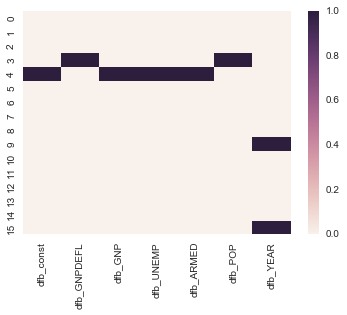

In [12]:
sns.heatmap(infl.summary_frame().filter(regex="dfb") > 0.5 )

## Flexible Modeling

The Guerry dataset is a collection of historical data used in support of Andre-Michel Guerry’s 1833 "Essay on the Moral Statistics of France."

>Andre-Michel Guerry’s (1833) Essai sur la Statistique Morale
de la France was one of the foundation studies of modern social science.
Guerry assembled data on crimes, suicides, literacy and other “moral
statistics,” and used tables and maps to analyze a variety of social issues
in perhaps the first comprehensive study relating such variables.

Wikipedia

>Guerry’s results were startling for two reasons.
First he showed that rates of crime and suicide remained
remarkably stable over time, when broken
down by age, sex, region of France and even season
of the year; yet these numbers varied systematically
across departements of France. This regularity
of social numbers created the possibility to
conceive, for the first time, that human actions in
the social world were governed by social laws, just
as inanimate objects were governed by laws of the
physical world.

Source: "A.-M. Guerry’s Moral Statistics of France: Challenges for Multivariable
Spatial Analysis", Michael Friendly.  Statistical Science 2007, Vol. 22, No. 3, 368–399.

In [13]:
# Lottery is per-capital wager on Royal Lottery
df = sm.datasets.get_rdataset("Guerry", "HistData").data
df = df[['Lottery', 'Literacy', 'Wealth', 'Region']].dropna()
df.head()

,Lottery,Literacy,Wealth,Region
0,41,37,73,E
1,38,51,22,N
2,66,13,61,C
3,80,46,76,E
4,79,69,83,E


We can use another version of the module that can directly type formulas and expressions in the functions of the models.


We can specify the name of the columns to be used to predict another column, remove columns, etc.

In [14]:
mod = smf.ols(formula='Lottery ~ Literacy + Wealth + Region', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Mon, 14 Nov 2016   Prob (F-statistic):           1.07e-05
Time:                        20:37:53   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      

__Categorical variables__

Patsy is the name of the interpreter that parses the formulas.

Looking at the summary printed above, notice that patsy determined that elements of Region were text strings, so it treated Region as a categorical variable. patsy‘s default is also to include an intercept, so we automatically dropped one of the Region categories.

__Removing variables__

The “-” sign can be used to remove columns/variables. For instance, we can remove the intercept from a model by:

In [15]:
res = smf.ols(formula='Lottery ~ Literacy + Wealth + C(Region) -1 ', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Mon, 14 Nov 2016   Prob (F-statistic):           1.07e-05
Time:                        20:37:53   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
C(Region)[C]    38.6517      9.456      4.087   

__Functions__

We can also apply vectorized functions to the variables in our model:

In [16]:
res = smf.ols(formula='Lottery ~ np.log(Literacy)', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     15.89
Date:                Mon, 14 Nov 2016   Prob (F-statistic):           0.000144
Time:                        20:37:53   Log-Likelihood:                -385.38
No. Observations:                  85   AIC:                             774.8
Df Residuals:                      83   BIC:                             779.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          115.6091     18.374  

In [17]:
from statsmodels.compat import lzip

In [18]:
from statsmodels.formula.api import ols

prestige = sm.datasets.get_rdataset("Duncan", "car", cache=True).data


In [19]:
prestige.head()

,type,income,education,prestige
accountant,prof,62,86,82
pilot,prof,72,76,83
architect,prof,75,92,90
author,prof,55,90,76
chemist,prof,64,86,90


In [20]:
prestige_model = ols("prestige ~ income + education", data=prestige).fit()
print(prestige_model.summary())


                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     101.2
Date:                Mon, 14 Nov 2016   Prob (F-statistic):           8.65e-17
Time:                        20:37:54   Log-Likelihood:                -178.98
No. Observations:                  45   AIC:                             364.0
Df Residuals:                      42   BIC:                             369.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.0647      4.272     -1.420      0.1

Influence plots


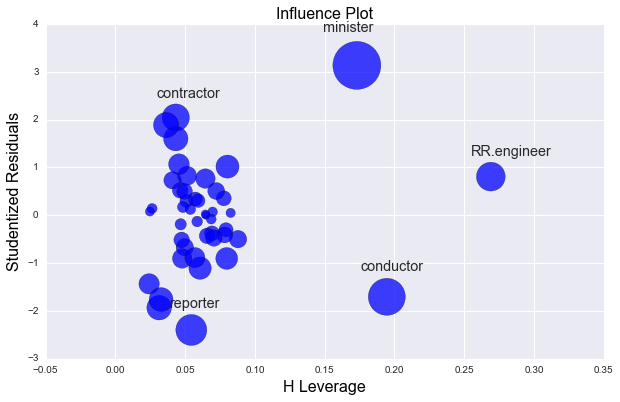

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(prestige_model, ax=ax, criterion="cooks")

As you can see there are a few worrisome observations. Both contractor and reporter have low leverage but a large residual. 
RR.engineer has small residual and large leverage. Conductor and minister have both high leverage and large residuals, and, 
therefore, large influence.

Partial Regression Plots

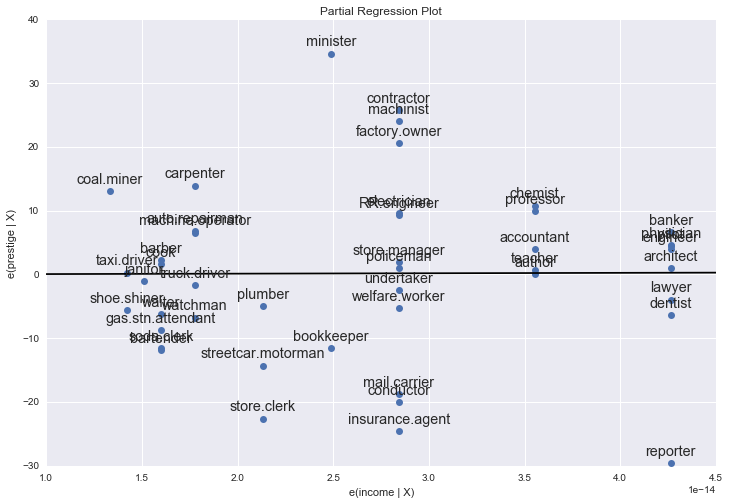

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_partregress("prestige", "income", ["income", "education"], data=prestige, ax=ax)


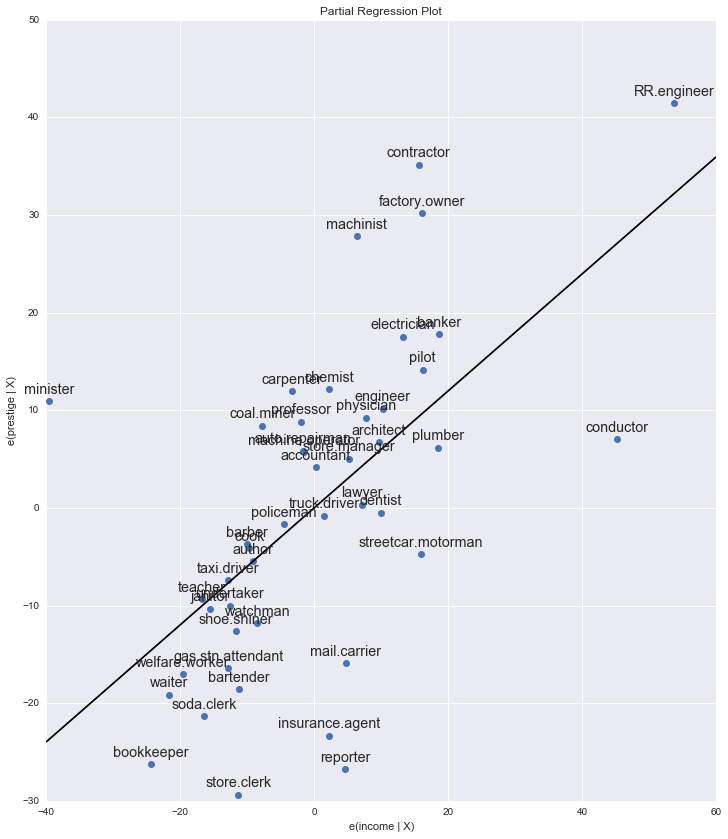

In [23]:

fix, ax = plt.subplots(figsize=(12,14))
fig = sm.graphics.plot_partregress("prestige", "income", ["education"], data=prestige, ax=ax)

As you can see the partial regression plot confirms the influence of conductor, minister, and RR.engineer on the partial relationship between income and prestige. The cases greatly decrease the effect of income on prestige. Dropping these cases confirms this.

In [24]:
subset = ~prestige.index.isin(["conductor", "RR.engineer", "minister"])
prestige_model2 = ols("prestige ~ income + education", data=prestige, subset=subset).fit()
print(prestige_model2.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     138.1
Date:                Mon, 14 Nov 2016   Prob (F-statistic):           2.02e-18
Time:                        20:37:55   Log-Likelihood:                -160.59
No. Observations:                  42   AIC:                             327.2
Df Residuals:                      39   BIC:                             332.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.3174      3.680     -1.717      0.0

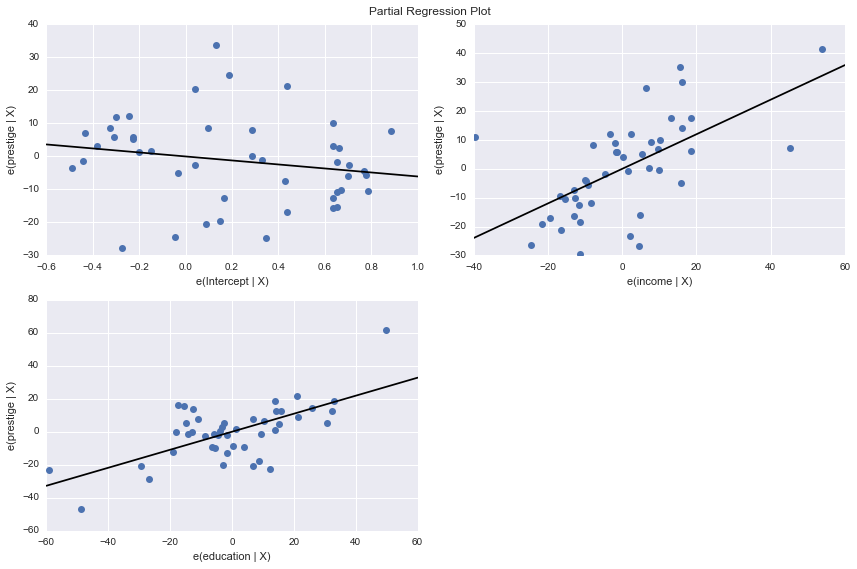

In [25]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(prestige_model, fig=fig)

More here:
    http://statsmodels.sourceforge.net/stable/examples/notebooks/generated/regression_plots.html
        

Using sklearn

In [26]:
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns
%matplotlib inline

In [27]:

X, y = datasets.make_regression(n_samples=100, n_features=20, n_informative=5, bias=0.1, noise=30, random_state=1)
print(X.shape, y.shape)

(100, 20) (100,)


In [28]:
model = sm.OLS(y, X)
results = model.fit()
print (results.summary())
print("Confidence Intervals:", results.conf_int())
print ("Parameters:", results.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     123.8
Date:                Mon, 14 Nov 2016   Prob (F-statistic):           1.03e-51
Time:                        20:37:55   Log-Likelihood:                -468.30
No. Observations:                 100   AIC:                             976.6
Df Residuals:                      80   BIC:                             1029.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            12.5673      3.471      3.620      0.0